TR AUTO - run 0

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from iminuit.cost import LeastSquares
import sys
sys.path.append('../src/analysis/fitting')  

from FitAPI import Fitter, Model
import models as md
from searcher import ResonancePeakSearcher

In [2]:
R_true = 2.317

def read_peaks_data_2(filename):
    data_dict = {}       # stores the dataset values as NumPy arrays
    metadata_dict = {}   # stores the metadata (attributes) for each dataset
    def process_dataset(name, obj):
        if isinstance(obj, h5py.Dataset):
            bias_voltage = float(obj.attrs.get("bias_voltage"))
            bias_key = bias_voltage/R_true 
            if bias_key is not None:
                data_dict[bias_key] = obj[()]
                metadata_dict[bias_key] = {k: v for k, v in obj.attrs.items()}
            else:
                print(f"Warning: Dataset '{name}' missing 'bias_voltage' attribute.")

    with h5py.File(filename, 'r') as f:
        f.visititems(process_dataset)

    return data_dict, metadata_dict

KeyError: 'fmin'

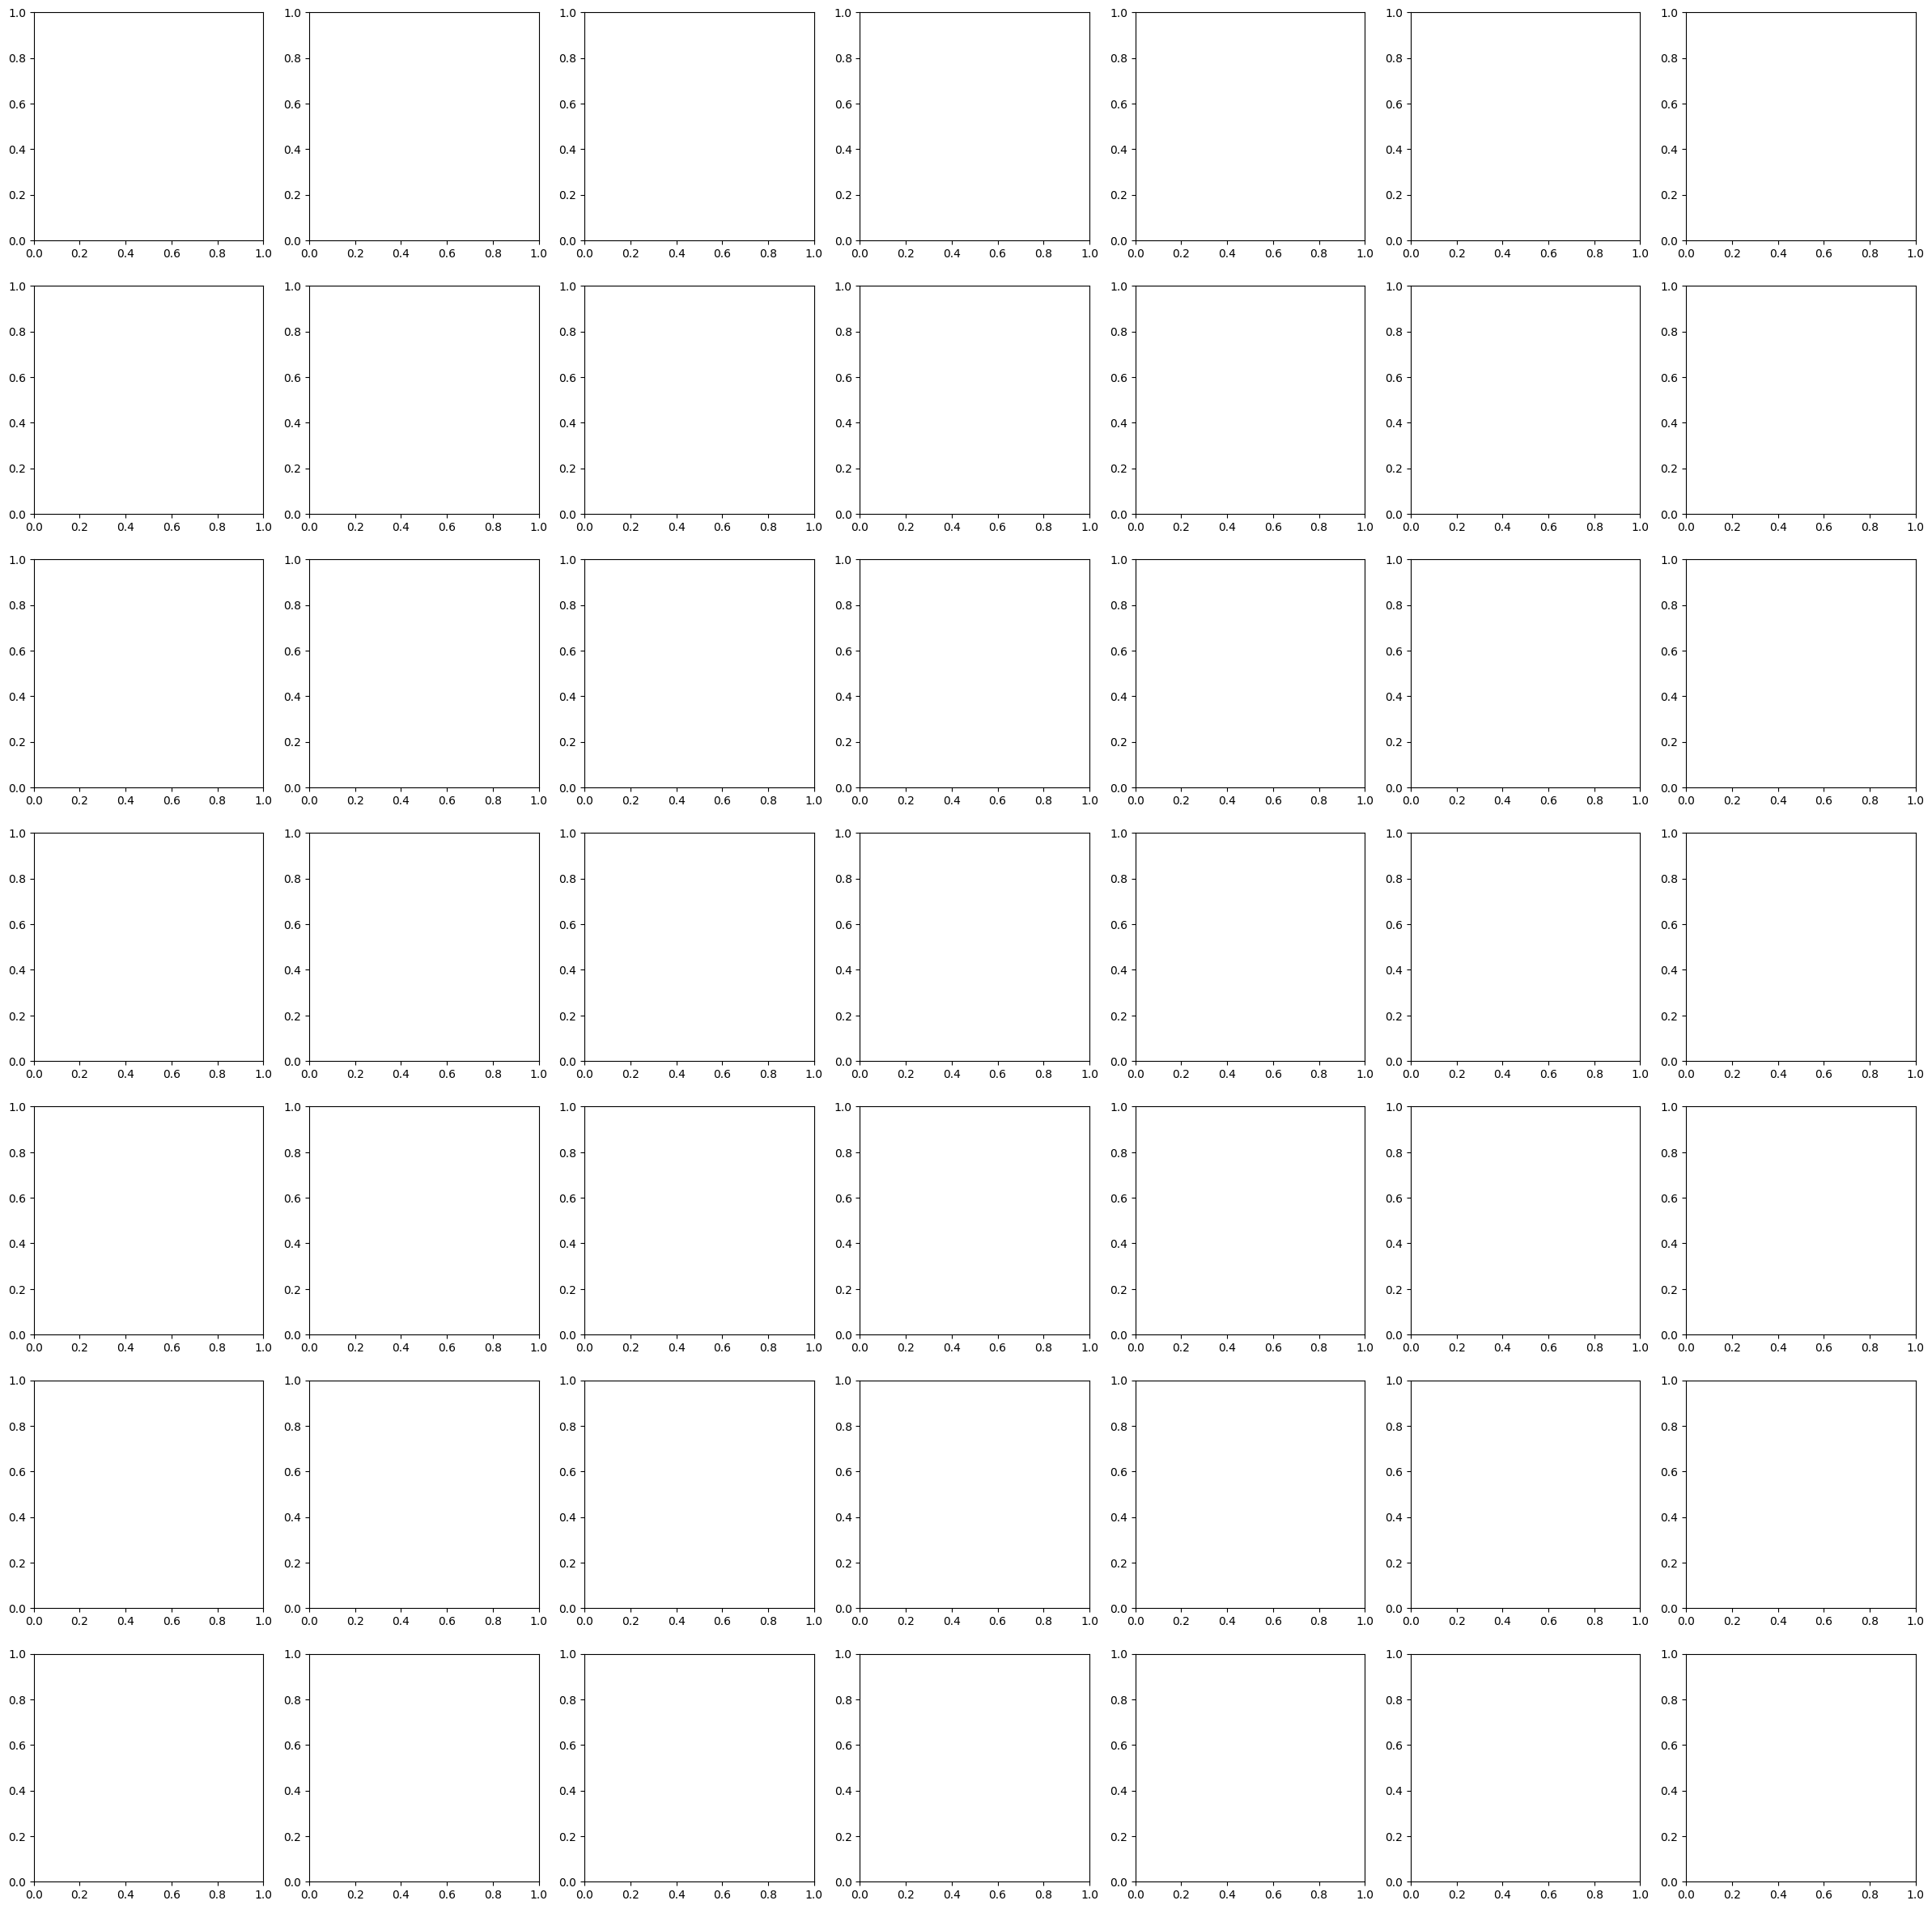

In [3]:
peak_data_dict, _ = read_peaks_data_2('../Experiments/TRswipeAuto/run-0/data/tr_sweep_data.h5')

resonance_frequneces = []
bias_currents = []
Qt = []
Qc = []

nof_peaks = len(peak_data_dict) - 4 # Exclude the last 4 peaks (assumed to be non-resonance peaks)
# Calculate grid size to accommodate all peaks
grid_size = int(np.ceil(np.sqrt(nof_peaks)))
fig, ax = plt.subplots(grid_size, grid_size, figsize=(30, 30))
row_iter = 0
col_iter = 0

for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    amp_dBm = 20 * np.log10(amp * 1e3)  # Convert to dBm
    peak_data = np.array([f, amp_dBm]).T
    
    # try to fit
    model = md.resonance_model
    fitter = Fitter(model_function=md.resonance_model, 
                        param_names=["f0", "phi", "Qt", "Qc", "A", "B", "C", "D", "K", "fmin"], 
                        data=peak_data, 
                        loss_function=LeastSquares
                    )

    searcher = ResonancePeakSearcher()
    result = fitter.fit(searcher=searcher)

    # Check if the fit was successful
    if result.valid:
        # p-value test
        p_value = fitter.p_value()
        if p_value < 0.05:
            print(f"Fit for bias current {bias_current} failed (p-value: {p_value})")
            # For now we take the fmin as the resonance frequency
            resonance_frequency = searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            continue
        else:
            # Extract the resonance frequency from the fitted parameters
            resonance_frequency = result.values['f0'] + searcher.params['fmin']
            resonance_frequneces.append(resonance_frequency)
            bias_currents.append(bias_current)
            # Plot the fit result
            fitted_params = result.values.to_dict()
            fitted_params['fmin'] = searcher.params['fmin']
            ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
            ax[row_iter, col_iter].plot(peak_data[:, 0], model(peak_data[:, 0], *fitted_params.values()), label='Fit', color='red')
            # add labels, title and legend
            ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
            ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
            ax[row_iter, col_iter].set_title(f'{round(bias_current, 3)} mA')
            ax[row_iter, col_iter].legend()
            ax[row_iter, col_iter].grid()
            
            Qt.append(fitted_params['Qt'])
            Qc.append(fitted_params['Qc'])
    else:
        print(f"Fit for bias current {bias_current} failed (invalid result)")
        # For now we take the fmin as the resonance frequency
        resonance_frequency = searcher.params['fmin']
        resonance_frequneces.append(resonance_frequency)
        bias_currents.append(bias_current)
        # Plot anyway the data
        ax[row_iter, col_iter].scatter(peak_data[:, 0], peak_data[:, 1], label='Data', color='blue', alpha=0.5, s=4)
        # add labels, title and legend
        ax[row_iter, col_iter].set_xlabel('Frequency (GHz)')
        ax[row_iter, col_iter].set_ylabel('Amplitude (dBm)')
        ax[row_iter, col_iter].set_title(f'{round(bias_current, 3)} mA')
        ax[row_iter, col_iter].legend()
        ax[row_iter, col_iter].grid()

    # update iterators
    col_iter += 1
    if col_iter >= grid_size:
        col_iter = 0
        row_iter += 1
        
   
        
# Hide unused subplots
total_plots = row_iter * grid_size + col_iter
for i in range(total_plots, grid_size * grid_size):
    ax.flat[i].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# Renormalize the resonance frequencies with respect to the frequency at 0 bias current
resonance_frequneces_normalized = np.array(resonance_frequneces)
bias_currents = np.array(bias_currents)
resonance_frequneces_normalized -= resonance_frequneces[0]
resonance_frequneces_normalized /= resonance_frequneces[0] if resonance_frequneces[0] != 0 else 1

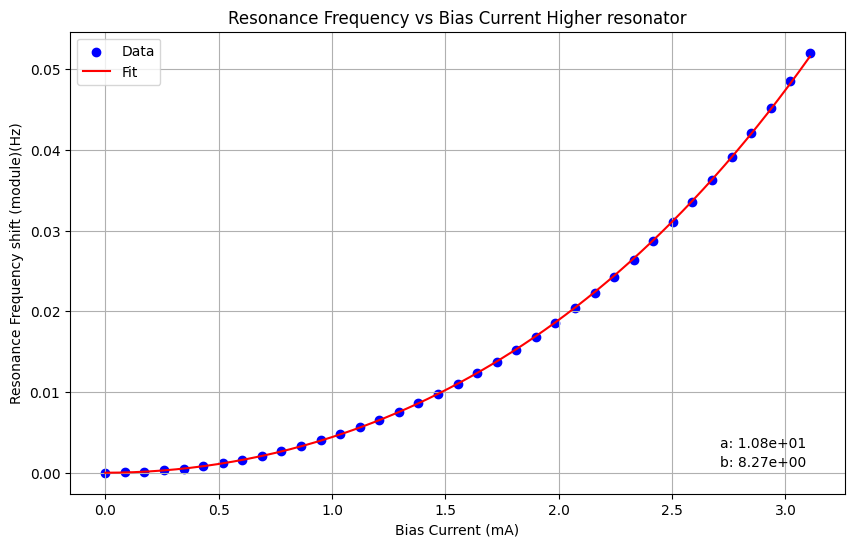

total quality factor Qt: [17837.870470127506, 17795.72319630538, 17918.237779776595, 17936.76829508447, 17216.183431444264, 17640.1498427448, 17966.12694836727, 18391.659629493606, 19893.490442987764, 19449.18753093066, 20299.75615135692, 15891.742683734295, 20044.49942972731, 21502.470363772292, 15866.822452595045, 19974.038981180125, 20691.648627095496, 17279.884019076322, 16823.996421177995, 14927.875132643481, 13894.911600290401, 12056.114355274256, 11916.590866197947, 11291.171209356902, 9480.627282607773, 11718.457130049606, 10542.986123065952, 9532.305414101997, 9330.733319313813, 8842.530152814377, 7442.853533686041, 8262.603026559722, 8151.025507410139, 7614.497364800527, 7000.396424402585, 7080.006148684719, 6929.304304639454]
coupling quality factor Qc: [-21622.669850668783, 22032.775756374132, -22398.112081630476, -22901.983597483955, 19753.715673146628, -22694.99165424364, -22544.64528431382, -25375.101988150273, -12320.354427162301, -12899.379857371583, -12658.93918673055

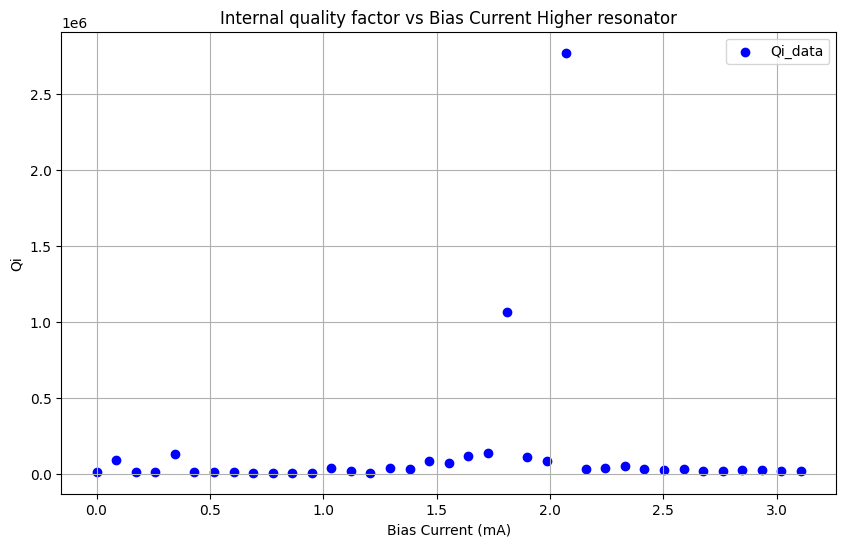

In [ ]:
# Fit resonance frequency vs bias current
model = md.parametric_resonator_peak_vs_bias_current
fitter = Fitter(model_function=model, 
                    param_names=["a", "b"], 
                    data=np.array([bias_currents, abs(resonance_frequneces_normalized)]).T, 
                    loss_function=LeastSquares,
                    params_initial_guess={"a": 1, "b": 1}, # initial guess for the parameters
                )



result = fitter.fit()
fitted_params = result.values.to_dict()

# test_params = {
#     "a": -1e4,
#     "b": -1e3,
# }

# Plot the resonance frequencies vs bias currents
plt.figure(figsize=(10, 6))
plt.scatter(bias_currents, abs(resonance_frequneces_normalized), color='blue', label='Data')
linspace = np.linspace(min(bias_currents), max(bias_currents), 200)
plt.plot(linspace, model(linspace, *fitted_params.values()), label='Fit', color='red')
# plt.plot(bias_currents, model(bias_currents, *test_params.values()), label='Test', color='green', linestyle='--')
# Add a and b to the plot
plt.text(0.95, 0.1, f'a: {fitted_params["a"]:.2e}', transform=plt.gca().transAxes, ha='right')
plt.text(0.95, 0.06, f'b: {fitted_params["b"]:.2e}', transform=plt.gca().transAxes, ha='right')

plt.xlabel('Bias Current (mA)')
plt.ylabel('Resonance Frequency shift (module)(Hz)')
plt.title('Resonance Frequency vs Bias Current Higher resonator')
plt.legend()
plt.grid()
plt.show()

print("total quality factor Qt:", Qt)
print("coupling quality factor Qc:", Qc)
#graph Qi as a function of bias current
#create Qi array: 1/Qi = 1/Qt - 1/Qc
Qi = abs(1 / np.array(Qt) - 1 / np.array(Qc))** -1  
plt.figure(figsize=(10, 6))
plt.scatter(bias_currents, Qi, label='Qi_data', color='blue')
plt.xlabel('Bias Current (mA)')
plt.ylabel('Qi')
plt.title('Internal quality factor vs Bias Current Higher resonator')
plt.legend()
plt.grid()
plt.show()


F(I) gradient plot (to be fixed)

In [ ]:
peak_data

array([[ 5.88182000e+09,  5.88182751e+09,  5.88183502e+09, ...,
         5.88930498e+09,  5.88931249e+09,  5.88932000e+09],
       [-1.64066927e-02, -1.70615392e-02, -1.62847356e-02, ...,
         3.61652918e-02,  3.53263494e-02,  3.52834024e-02],
       [ 2.74783655e-02,  2.89264500e-02,  2.75738108e-02, ...,
         9.34419210e-03,  9.17023870e-03,  9.40279520e-03]],
      shape=(3, 1000))

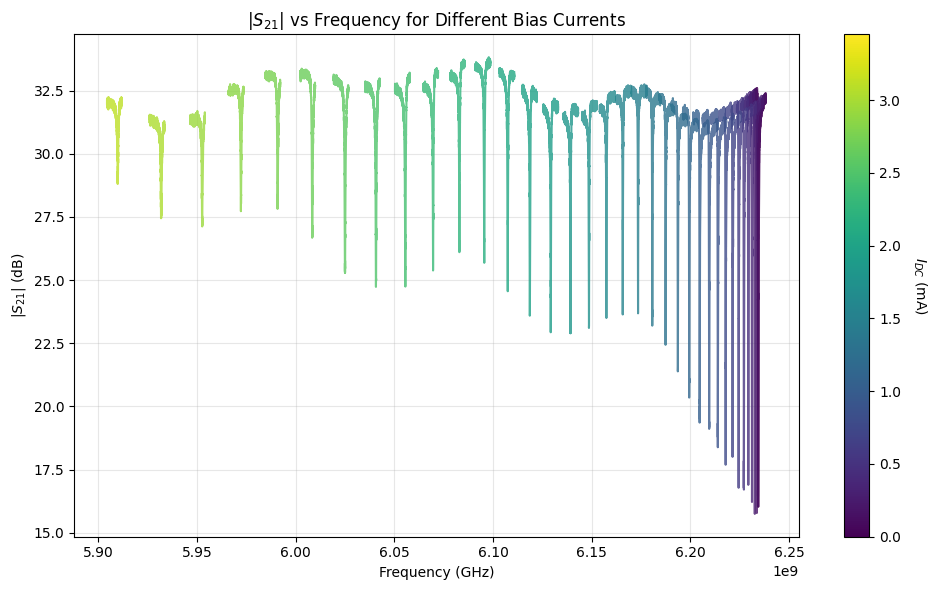

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Trova i valori min e max dei bias current per normalizzare la colormap
all_bias_currents = list(peak_data_dict.keys())
vmin = min(all_bias_currents)
vmax = max(all_bias_currents)
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap('viridis')

for i, (bias_current, peak_data) in enumerate(peak_data_dict.items()):
     
    # Break the cycle for the last 4 values of current:
    if i >= nof_peaks:
        break
    
    f = peak_data[0]
    I = peak_data[1]
    Q = peak_data[2]
    amp = np.sqrt(I**2 + Q**2)
    S21_mag = 20 * np.log10(amp * 1e3)
    color = cmap(norm(bias_current))
    plt.plot(f, S21_mag, color=color, linewidth=1.5, alpha=0.8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(r'$I_{DC}$ (mA)', rotation=270, labelpad=20)

# Formatting
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'$|S_{21}|$ (dB)')
plt.title(r'$|S_{21}|$ vs Frequency for Different Bias Currents')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

